In [1]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with rio.open('D:/thesis_data/SAR/preprocessed/SLC/C2_20170112T084450_32723.tif') as src:
    # Read the C2 matrix components as numpy arrays
    c11 = src.read(1)
    c12_real = src.read(2)
    c12_imag = src.read(3)
    c22 = src.read(4)

In [3]:
c12 = c12_real + 1j * c12_imag
c21 = np.conjugate(c12)

In [4]:
m, n = c11.shape

In [5]:
det_C2 = c11*c22 - c12*c21

In [6]:
# Calculate the coherency matrix components
t11 = (c11 + c22)/2
t12 = (c11 - c22)/2j
t21 = (c12 + c21)/2
t22 = (c12 - c21)/2j

In [7]:
# Calculate the Stokes matrix
s = np.array([t11+t22, t11-t22, 2*t21.real, -2*t21.imag])

In [8]:
# Calculate the eigenvalues and eigenvectors of the coherency matrix
c2 = np.array([[c11, c12], [c21, c22]])

In [26]:
C2_flat = np.reshape(c2, (m*n, 2, 2))

In [27]:
# calculate the eigendecomposition for each C2 matrix using vectorization
eigenvals, eigenvecs = np.linalg.eig(C2_flat)

In [28]:
# reshape the eigenvalues and eigenvectors back to the original 4D shape
eigenvals = np.reshape(eigenvals, (m, n, 2))
eigenvecs = np.reshape(eigenvecs, (m, n, 2, 2))

In [33]:
# Sort the eigenvalues in descending order and rearrange the corresponding eigenvectors
sort_idx = np.argsort(np.abs(eigenvals), axis=-1)[..., ::-1]

In [34]:
eigenvalues = np.take_along_axis(eigenvals, sort_idx, axis=-1)
eigenvectors = np.take_along_axis(eigenvecs, sort_idx[..., np.newaxis, :], axis=-1)

In [39]:
# Calculate Yamaguchi parameters
d = eigenvalues[..., 0].real
phi = np.angle(eigenvectors[..., 1, 0])
psi = np.angle(eigenvectors[..., 0, 0] * np.conj(eigenvectors[..., 1, 1]))

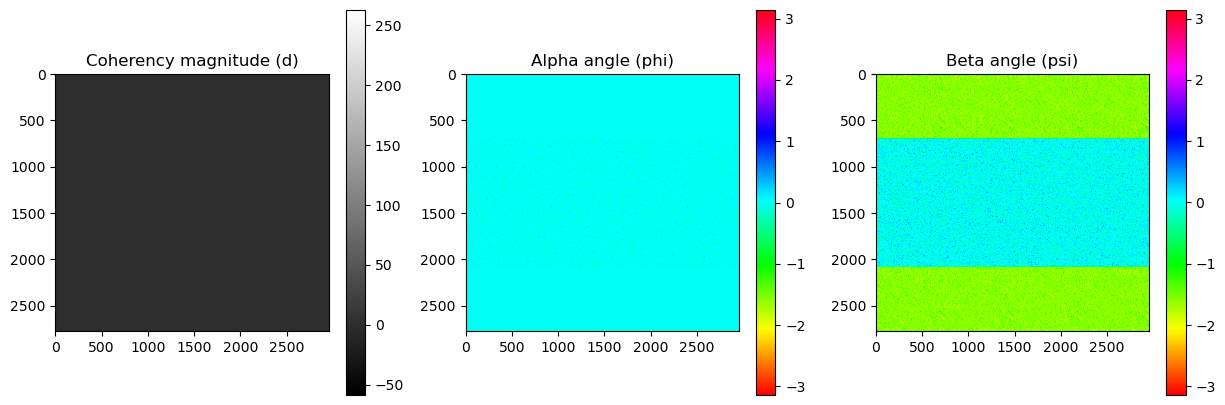

In [41]:
# Plot Yamaguchi parameters
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(d, cmap='gray')
plt.colorbar()
plt.title('Coherency magnitude (d)')
plt.subplot(1, 3, 2)
plt.imshow(phi, cmap='hsv')
plt.colorbar()
plt.title('Alpha angle (phi)')
plt.subplot(1, 3, 3)
plt.imshow(psi, cmap='hsv')
plt.colorbar()
plt.title('Beta angle (psi)')
plt.show()

In [15]:
# Initialize arrays for eigenvalues and eigenvectors
l1 = np.zeros((m, n))
l2 = np.zeros((m, n))
v1 = np.zeros((m, n, 2))
v2 = np.zeros((m, n, 2))

In [16]:
for i in range(m):
    for j in range(n):
        # Construct C2 matrix for pixel i,j
        C2 = np.array([[c11[i,j], c12[i,j]], [c21[i,j], c22[i,j]]])
        # Calculate eigendecomposition of C2
        l, v = np.linalg.eig(C2)
        # Sort eigenvalues in descending order
        idx = np.argsort(l)[::-1]
        # Store eigenvalues and eigenvectors in output arrays
        l1[i,j] = l[idx[0]]
        l2[i,j] = l[idx[1]]
        v1[i,j,:] = v[:,idx[0]]
        v2[i,j,:] = v[:,idx[1]]

C:\Users\jales\AppData\Local\Temp\ipykernel_26060\1477919440.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  l1[i,j] = l[idx[0]]
C:\Users\jales\AppData\Local\Temp\ipykernel_26060\1477919440.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  l2[i,j] = l[idx[1]]
C:\Users\jales\AppData\Local\Temp\ipykernel_26060\1477919440.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[i,j,:] = v[:,idx[0]]
C:\Users\jales\AppData\Local\Temp\ipykernel_26060\1477919440.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[i,j,:] = v[:,idx[1]]


In [18]:
# Normalize eigenvectors
v1_norm = np.linalg.norm(v1, axis=-1)
v2_norm = np.linalg.norm(v2, axis=-1)
v1 = v1 / v1_norm[..., np.newaxis]
v2 = v2 / v2_norm[..., np.newaxis]

In [19]:
# Calculate Pauli decomposition parameters
alpha = np.arctan2(v2[:,:,1], v2[:,:,0])
rho = (l1-l2) / (l1+l2)
tau = 2*l2 / (l1+l2)

In [20]:
# Calculate Yamaguchi decomposition parameters
entropy = -rho*np.log2(rho) - (1-rho)*np.log2(1-rho)
anisotropy = (l1-l2) / l1
alpha_y = 0.5*np.arctan2(v2[:,:,1], v2[:,:,0] + v1[:,:,0])

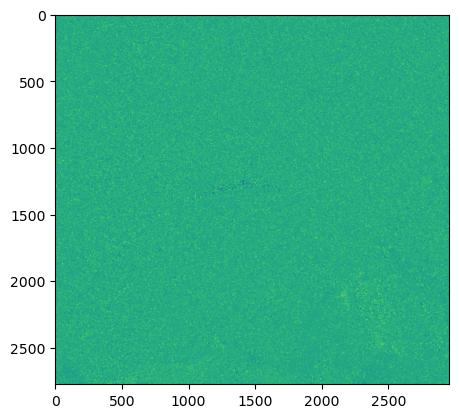

In [23]:
plt.imshow(alpha_y)